In [8]:
from scipy.spatial.distance import squareform
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sys import argv
import os

In [5]:
meta = pd.read_csv('/home/kurmukov/connective_parcellation_old/HCP/RESTRICTED_kurmukovai_3_20_2018_0_51_16.csv')

In [39]:
a = np.arange(10)

In [40]:
np.random.shuffle(a)

In [41]:
a

array([7, 4, 8, 1, 3, 6, 2, 0, 5, 9])

In [6]:
meta

,Subject,Age_in_Yrs,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,Race,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
0,100004,24,True,NotTwin,,52259_82122,52259,82122,NaN,White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
1,100206,27,True,NotTwin,,56037_85858,56037,85858,NaN,White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,100307,27,True,NotMZ,MZ,51488_81352,51488,81352,NaN,White,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0
3,100408,33,True,MZ,MZ,51730_81594,51730,81594,NaN,White,...,4.0,5.0,5.0,5.0,0.0,0.0,1.0,1.0,2.0,4.0
4,100610,27,True,NotMZ,DZ,52813_82634,52813,82634,NaN,White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
5,101006,35,True,MZ,,51283_52850_81149,51283,81149,NaN,Black or African Am.,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.0
6,101107,22,True,NotTwin,,51969_81833,51969,81833,NaN,White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
7,101208,35,True,NotMZ,DZ,51330_81195,51330,81195,NaN,Black or African Am.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
8,101309,29,True,NotTwin,,52385_82248,52385,82248,NaN,Black or African Am.,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
9,101410,29,True,NotMZ,,52198_82061,52198,82061,NaN,White,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0


In [18]:
subjects = [int(n.split('.')[0]) for n in os.listdir('/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/Aver_level1/10/')]

In [19]:
age = []
sid = []
for row in meta.itertuples():
    if row.Subject in subjects:
        sid.append(row.Subject)
        age.append(row.Age_in_Yrs)

In [22]:
meta = pd.read_csv('/home/kurmukov/connective_parcellation_old/HCP/old_code/unrestricted_hcp_freesurfer.csv')

In [28]:
sex = []
for s in sid:
    sex.append(meta[meta.Subject==s].Gender.values[0])
    

In [31]:
meta = pd.DataFrame(sid, columns=['Subject'])
meta['Age'] = age
meta['Gender'] = sex

In [34]:
meta.groupby('Gender')['Age'].agg(['mean', 'std'])

,mean,std
Gender,,
F,29.313953,3.623083
M,28.000000,3.727139


In [36]:
meta.Gender.value_counts()

F    258
M    167
Name: Gender, dtype: int64

In [35]:
def get_X_y(con_folder):
#     '/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/HE_level3/100/'
    connectomes = sorted(glob(f'{con_folder}*.npy'))

    subject_ids = []
    edges = []
    for c in connectomes:
        sid = int(c.split('/')[-1].split('.')[0])
        if sid != 142626:
            subject_ids.append(sid)
            adj = np.load(c)
            edges.append(squareform(adj))

    meta = pd.read_csv('/home/kurmukov/connective_parcellation_old/HCP/old_code/unrestricted_hcp_freesurfer.csv')
    meta['1_0_gender'] = meta['Gender'].map({'F':0,'M':1})
    sex = dict(zip(meta['Subject'], meta['1_0_gender']))
    y=[sex.get(s) for s in subject_ids]

    y = np.array(y)
    X = np.array(edges)
    return X, y

In [15]:
def model_eval(X, y, random_state=10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                        random_state=random_state)
    model = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1',
                                                               random_state=random_state,
                                                               solver='liblinear'))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=random_state)
    score = make_scorer(roc_auc_score, needs_proba=True)
    params={
        
    'logisticregression__C': [0.001, 0.003, 0.01, 0.03,
                              0.1,   0.3,   1,    5,
                              10,    20,    50,   100,
                              150,   180,   200,  220,
                              250,   300,   400,  500]
    }
    gs = GridSearchCV(model,
                      param_grid=params,
                      cv = cv,
                      scoring=score,
                      n_jobs=20,
                      iid=False,
                      refit=True)
    

    gs.fit(X_train, y_train)
    y_pred = gs.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, y_pred[:, 1])
    
    return gs, auc_test

def store_results(gs, auc_test, data_descr=None):
    '''
    data_descr = {
        'ensemble': 'HE',
        'level': 3,
        'sparsity': 10
    }
    '''
    ind = np.argmax(gs.cv_results_['mean_test_score'])
    cv_mean = gs.cv_results_['mean_test_score'][ind]
    cv_std = gs.cv_results_['std_test_score'][ind]
    cv_C = gs.best_params_['logisticregression__C']
    df_results = pd.DataFrame(data = [[cv_mean, cv_std, 
                                      auc_test, cv_C,
                                      data_descr['ensemble'], data_descr['level'],
                                      data_descr['sparsity'], data_descr['n_features'],
                                      data_descr['non_zero']]],
                              columns=['cv_mean', 'cv_std',
                                       'test_mean', 'C',
                                       'ensemble', 'level',
                                       'sparsity', 'n_features',
                                       'non_zero'])
    name = f"{data_descr['ensemble']}_{data_descr['level']}_{data_descr['sparsity']}"
#     df_results.to_csv(f'./model_eval_results/{name}.csv')
    return df_results

In [ ]:
if __name__ == "__main__":
    ensemble = argv[1] # HE, CSPA, Aver, Desikan_aparc, Destrieux_aparc2009
#     level = argv[2] # 1,2,3
    if ensemble == 'Desikan_aparc' or ensemble == 'Destrieux_aparc2009':
        df = []
        for sparsity in tqdm(range(10, 101, 10)):
            subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/{ensemble}_resolution/{sparsity}/'
            X, y = get_X_y(subject_folder)
            gs, auc = model_eval(X, y)
            descr = {
                'ensemble': ensemble,
                'level': 0,
                'sparsity': sparsity,
                'n_features': gs.best_estimator_.steps[1][1].coef_.shape[1],
                'non_zero': np.nonzero(gs.best_estimator_.steps[1][1].coef_)[1].shape[0]
            }
            df.append(store_results(gs, auc, descr))

        df_all = df[0]
        for d in df[1:]:
            df_all = df_all.append(d, ignore_index=True)
        name = f"{descr['ensemble']}"
        df_all.to_csv(f'./model_eval_results/{name}.csv')
    else:
        for level in tqdm([1,2,3]):
            df = []
            for sparsity in tqdm(range(10, 101, 10)):
                subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/{ensemble}_level{level}/{sparsity}/'
                X, y = get_X_y(subject_folder)
                gs, auc = model_eval(X, y)
                descr = {
                    'ensemble': ensemble,
                    'level': level,
                    'sparsity': sparsity,
                    'n_features': gs.best_estimator_.steps[1][1].coef_.shape[1],
                    'non_zero': np.nonzero(gs.best_estimator_.steps[1][1].coef_)[1].shape[0]
                }
                df.append(store_results(gs, auc, descr))

            df_all = df[0]
            for d in df[1:]:
                df_all = df_all.append(d, ignore_index=True)
            name = f"{descr['ensemble']}_{descr['level']}"
            df_all.to_csv(f'./model_eval_results/{name}.csv')

In [37]:
ensemble = 'HE'#argv[1] # HE, CSPA, Aver
level = 1#argv[2] # 1,2,3
df = []
for sparsity in tqdm(range(10, 101, 10)):
    subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/{ensemble}_level{level}/{sparsity}/'
    X, y = get_X_y(subject_folder)
    gs, auc = model_eval(X, y)
    descr = {
        'ensemble': ensemble,
        'level': level,
        'sparsity': sparsity
    }
    df.append(store_results(gs, auc, descr))

df_all = df[0]
for d in df[1:]:
    df_all = df_all.append(d, ignore_index=True)

100%|██████████| 10/10 [00:35<00:00,  3.93s/it]


In [ ]:
if __name__ == "__main__":
    ensemble = argv[1] # HE, CSPA, Aver
    level = argv[2] # 1,2,3
    df = []
    for sparsity in range(10, 101, 10):
        subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/{ensemble}_level{level}/{sparsity}/'
        X, y = get_X_y(subject_folder)
        gs, auc = model_eval(X, y)
        descr = {
            'ensemble': ensemble,
            'level': level,
            'sparsity': sparsity,
            'n_features': gs.best_estimator_.steps[1][1].coef_.shape[1],
            'non_zero': np.nonzero(gs.best_estimator_.steps[1][1].coef_)[1].shape[0]
        }
        df.append(store_results(gs, auc, descr))
    
    df_all = df[0]
    for d in df[1:]:
        df_all = df_all.append(d, ignore_index=True)
    df_all.to_csv()
    
    name = f"{data_descr['ensemble']}_{data_descr['level']}"
    df_all.to_csv(f'./model_eval_results/{name}.csv')

In [ ]:
if __name__ == "__main__":
    ensemble = argv[1] # HE, CSPA, Aver
#     level = argv[2] # 1,2,3
    df = []
    for level in tqdm([1,2,3]):
        for sparsity in tqdm(range(10, 101, 10)):
            subject_folder = f'/data01/ayagoz/sparse_32_concon_HCP/connectomes/Ensemble_parcellation/{ensemble}_level{level}/{sparsity}/'
            X, y = get_X_y(subject_folder)
            gs, auc = model_eval(X, y)
            descr = {
                'ensemble': ensemble,
                'level': level,
                'sparsity': sparsity
            }
            df.append(store_results(gs, auc, descr))

        df_all = df[0]
        for d in df[1:]:
            df_all = df_all.append(d, ignore_index=True)

        name = f"{descr['ensemble']}_{descr['level']}"
        df_all.to_csv(f'./model_eval_results/{name}.csv')

In [29]:
X, y = get_X_y()

In [30]:
gs, auc_test = model_eval(X, y, random_state=10) #random_state=10, 15

In [63]:
np.nonzero(gs.best_estimator_.steps[1][1].coef_)[1].shape[0]

(15,)

In [31]:
auc_test

0.9308243727598566

In [32]:
summary = store_results(gs, auc_test, {
        'ensemble': 'HE',
        'level': 3,
        'sparsity': 10
    })

In [33]:
summary

,cv_mean,cv_std,test_mean,C,ensemble,level,sparsity
0,0.825247,0.07557,0.930824,300,HE,3,10


In [28]:
summary

,cv_mean,cv_std,test_mean,C,ensemble,level,sparsity
0,0.825247,0.07557,0.930824,300,HE,3,10


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=5)

In [91]:
model = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l1', random_state=5))
score = make_scorer(roc_auc_score, needs_proba=True)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats = 20, random_state=7)
params={
    'logisticregression__C': [10, 20, 50, 100, 150, 200, 250]
    #[0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 5, 10, 20, 50, 100, 150, 200, 250, 300, 500]
}
gs = GridSearchCV(model, param_grid=params, cv = cv, verbose=10, scoring=score, n_jobs=10)

gs.fit(X_train, y_train)

Fitting 100 folds for each of 7 candidates, totalling 700 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x7fd968e4ecf8>,
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scalin...
                                                           max_iter=100,
                                   

In [92]:
gs.best_score_, gs.best_params_

(0.8461710844600618, {'logisticregression__C': 200})

In [93]:
y_pred = gs.best_estimator_.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.8506787330316743

0.8506787330316743

In [26]:
900 * 2 / 60 / 2

15.0

In [42]:
np.nonzero(gs.best_estimator_.steps[1][1].coef_[0])[0].shape

(760,)

In [36]:
gs.

{'mean_fit_time': array([0.22394139, 0.2324709 , 0.23419703, 0.2359362 , 0.24164482,
        0.2436457 , 0.24337304, 0.23941186, 0.24295566, 0.24309497,
        0.2461503 ]),
 'std_fit_time': array([0.0149926 , 0.01484944, 0.01445942, 0.01515605, 0.01610822,
        0.01603605, 0.01599028, 0.01609449, 0.01497688, 0.01420934,
        0.01465033]),
 'mean_score_time': array([0.0022882 , 0.0022576 , 0.00226946, 0.00227227, 0.00225554,
        0.00224416, 0.00226556, 0.00225812, 0.00223923, 0.00222604,
        0.00223644]),
 'std_score_time': array([0.0002401 , 0.00018622, 0.00018036, 0.00017977, 0.00016619,
        0.00014541, 0.00015755, 0.000206  , 0.00015452, 0.00013052,
        0.00019414]),
 'param_logisticregression__C': masked_array(data=[1, 5, 10, 20, 50, 100, 150, 200, 250, 300, 500],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logisticregres

# Classification results

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import pandas as pd

In [6]:
results = glob('/home/kurmukov/connective_parcellation/concon_processing/model_eval_results/*_cv.csv')

In [7]:
df = pd.read_csv(results[0], index_col=0)
for f in results[1:]:
    temp = pd.read_csv(f, index_col=0)
    df = df.append(temp, ignore_index=True)

In [8]:
auc_test = df.test_mean
auc_mean = df.cv_mean
n_features = df.non_zero

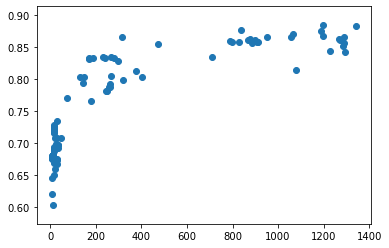

In [187]:
plt.scatter(n_features, auc_test);


In [195]:
87*88/2

3828.0

In [11]:
df.sort_values('test_mean', ascending=False)

,cv_mean,cv_std,test_mean,test_std,C,ensemble,level,sparsity,n_features,non_zero
84,0.897504,0.049363,0.884529,0.042939,400.0,Aver,3,50,4005,1198
89,0.901057,0.047503,0.882514,0.037512,500.0,Aver,3,100,4005,1343
79,0.881245,0.053428,0.877029,0.046335,180.0,HE,3,100,3570,838
88,0.901359,0.048227,0.875679,0.047527,400.0,Aver,3,90,4005,1189
86,0.900302,0.047541,0.871037,0.050476,300.0,Aver,3,70,4005,1065
107,0.891287,0.047256,0.868985,0.066569,20.0,Destrieux_aparc2009,0,80,10878,653
87,0.900930,0.048885,0.868232,0.048903,400.0,Aver,3,80,4005,1199
104,0.891674,0.046503,0.867295,0.051291,20.0,Destrieux_aparc2009,0,50,10878,642
78,0.885730,0.051068,0.866614,0.058431,500.0,HE,3,90,3486,1289
83,0.876965,0.057493,0.866296,0.052679,10.0,Aver,3,40,4186,315


In [198]:
df.query('test_mean > 0.8 and non_zero < 600').sort_values('test_mean', ascending=False)

,cv_mean,cv_std,test_mean,test_std,C,ensemble,level,sparsity,n_features,non_zero
83,0.876965,0.057493,0.866296,0.052679,10.0,Aver,3,40,4186,315
74,0.871575,0.055772,0.855382,0.034520,50.0,HE,3,50,3828,471
67,0.817683,0.064972,0.834455,0.056415,180.0,Aver,2,80,528,232
69,0.817872,0.064575,0.834087,0.058354,500.0,Aver,2,100,528,268
80,0.833917,0.060777,0.833849,0.048010,0.3,Aver,3,10,3741,187
65,0.817509,0.065245,0.833762,0.056977,1.0,Aver,2,60,528,170
66,0.817541,0.064500,0.833479,0.056932,220.0,Aver,2,70,528,241
68,0.818360,0.064898,0.832753,0.057130,220.0,Aver,2,90,528,281
64,0.816637,0.065202,0.831429,0.057266,1.0,Aver,2,50,528,170
63,0.807453,0.061910,0.829145,0.056157,500.0,Aver,2,40,561,296


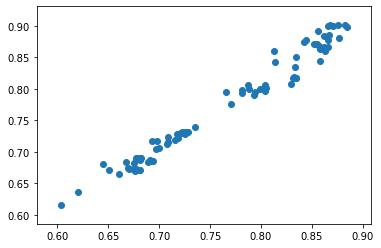

In [188]:
plt.scatter(auc_test, auc_mean)

In [171]:
df.shape

(90, 10)

In [175]:
# [df.ensemble=='HE']
df.sort_values('test_mean', ascending=False)

,cv_mean,cv_std,test_mean,test_std,C,ensemble,level,sparsity,n_features,non_zero
84,0.897504,0.049363,0.884529,0.042939,400.0,Aver,3,50,4005,1198
89,0.901057,0.047503,0.882514,0.037512,500.0,Aver,3,100,4005,1343
79,0.881245,0.053428,0.877029,0.046335,180.0,HE,3,100,3570,838
88,0.901359,0.048227,0.875679,0.047527,400.0,Aver,3,90,4005,1189
86,0.900302,0.047541,0.871037,0.050476,300.0,Aver,3,70,4005,1065
87,0.900930,0.048885,0.868232,0.048903,400.0,Aver,3,80,4005,1199
78,0.885730,0.051068,0.866614,0.058431,500.0,HE,3,90,3486,1289
83,0.876965,0.057493,0.866296,0.052679,10.0,Aver,3,40,4186,315
85,0.899888,0.047289,0.866256,0.045115,300.0,Aver,3,60,4005,1056
98,0.866271,0.053954,0.865943,0.055011,500.0,Desikan_aparc,0,90,2278,950


In [164]:
df[df.sparsity == 30].sort_values('cv_mean', ascending=False)

,cv_mean,cv_std,test_mean,test_std,C,ensemble,level,sparsity,n_features,non_zero
72,0.871120,0.057098,0.852027,0.055585,500.0,HE,3,30,3570,1287
82,0.866711,0.054920,0.862251,0.048947,500.0,Aver,3,30,3403,1268
52,0.800351,0.075400,0.798942,0.075404,500.0,HE,2,30,435,318
62,0.796403,0.067338,0.804109,0.060034,0.3,Aver,2,30,496,146
32,0.722029,0.083208,0.718381,0.040944,0.3,CSPA,2,30,28,15
42,0.714995,0.085990,0.708881,0.056491,0.3,CSPA,3,30,55,29
22,0.689860,0.084962,0.678850,0.093823,0.3,Aver,1,30,28,12
2,0.684070,0.080731,0.688482,0.116719,5.0,HE,1,30,28,15
12,0.669600,0.083008,0.675851,0.118017,0.3,CSPA,1,30,21,7


In [156]:
df[df.sparsity == 70].sort_values('cv_mean', ascending=False)

,cv_mean,cv_std,test_mean,C,ensemble,level,sparsity,n_features,non_zero
76,0.847477,0.074371,0.875986,0.3,HE,3,70,3655,153
106,0.846627,0.067090,0.863799,500.0,Destrieux_aparc2009,0,70,10878,2153
96,0.845635,0.063552,0.829391,250.0,Desikan_aparc,0,70,2278,640
86,0.845429,0.069191,0.900000,500.0,Aver,3,70,4005,1187
66,0.810955,0.069403,0.782079,500.0,Aver,2,70,528,260
36,0.756412,0.080372,0.788530,250.0,HE,2,70,465,211
26,0.674114,0.089502,0.786380,0.3,CSPA,2,70,28,16
56,0.660537,0.098291,0.725806,1.0,Aver,1,70,28,14
46,0.657986,0.096280,0.725806,0.3,CSPA,3,70,36,19
16,0.644398,0.099723,0.684588,10.0,CSPA,1,70,21,10


In [158]:
df[df.non_zero>100].sort_values('cv_mean', ascending=False)

,cv_mean,cv_std,test_mean,C,ensemble,level,sparsity,n_features,non_zero
104,0.851533,0.063825,0.855197,500.0,Destrieux_aparc2009,0,50,10878,2169
103,0.849074,0.067485,0.837634,500.0,Destrieux_aparc2009,0,40,10878,2177
72,0.848740,0.072363,0.868817,50.0,HE,3,30,3570,426
107,0.848562,0.065070,0.856989,500.0,Destrieux_aparc2009,0,80,10878,2153
89,0.848252,0.068705,0.872760,500.0,Aver,3,100,4005,1192
83,0.848228,0.073828,0.884229,5.0,Aver,3,40,4186,245
78,0.848099,0.070247,0.884946,500.0,HE,3,90,3486,1153
87,0.848039,0.068689,0.884229,500.0,Aver,3,80,4005,1188
76,0.847477,0.074371,0.875986,0.3,HE,3,70,3655,153
105,0.847272,0.068568,0.837993,500.0,Destrieux_aparc2009,0,60,10878,2205


In [99]:
# df.sort_values('test_mean', ascending=False)

In [100]:
# df.sort_values('cv_mean', ascending=False)

In [81]:
he_res = df[df['ensemble']=='HE']

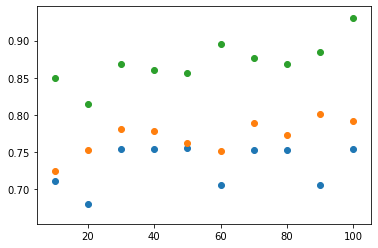

In [83]:
plt.scatter(he_res[he_res['level']==1]['sparsity'], he_res[he_res['level']==1]['test_mean'])

plt.scatter(he_res[he_res['level']==2]['sparsity'], he_res[he_res['level']==2]['test_mean'])

plt.scatter(he_res[he_res['level']==3]['sparsity'], he_res[he_res['level']==3]['test_mean'])

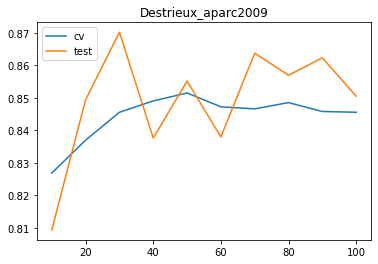

In [109]:
p = 'Destrieux_aparc2009'
parc =  df[df['ensemble']==p]
parc = parc.sort_values('sparsity')
x = parc['sparsity'].values
y_cv = parc['cv_mean']
y_test = parc['test_mean']

plt.plot(x, y_cv, label='cv')
plt.plot(x, y_test, label='test')
plt.legend()
plt.title(p);

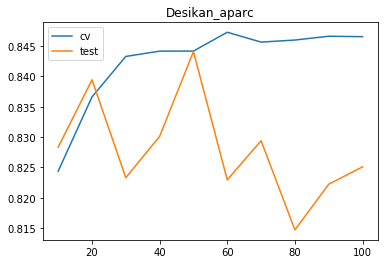

In [110]:
p = 'Desikan_aparc'
parc =  df[df['ensemble']==p]
parc = parc.sort_values('sparsity')
x = parc['sparsity'].values
y_cv = parc['cv_mean']
y_test = parc['test_mean']

plt.plot(x, y_cv, label='cv')
plt.plot(x, y_test, label='test')
plt.legend()
plt.title(p);

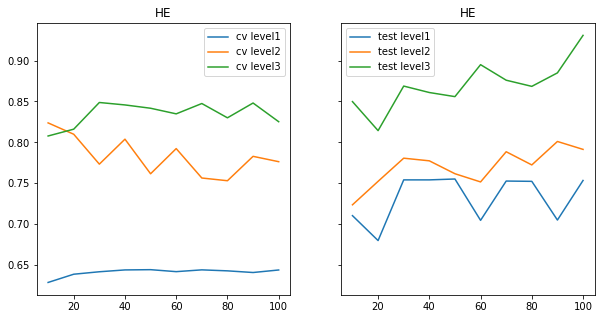

In [127]:
p = 'HE'
parc =  df[df['ensemble']==p]
parc = parc.sort_values(['level','sparsity'])
x = parc['sparsity'].values
y_cv = parc['cv_mean'].values
y_test = parc['test_mean'].values

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax[0].plot(x[:10], y_cv[:10], label='cv level1')
ax[0].plot(x[10:20], y_cv[10:20], label='cv level2')
ax[0].plot(x[20:], y_cv[20:], label='cv level3')

ax[0].legend()
ax[0].set_title(p);

ax[1].plot(x[:10], y_test[:10], label='test level1')
ax[1].plot(x[10:20], y_test[10:20], label='test level2')
ax[1].plot(x[20:], y_test[20:], label='test level3')


ax[1].legend()
ax[1].set_title(p);

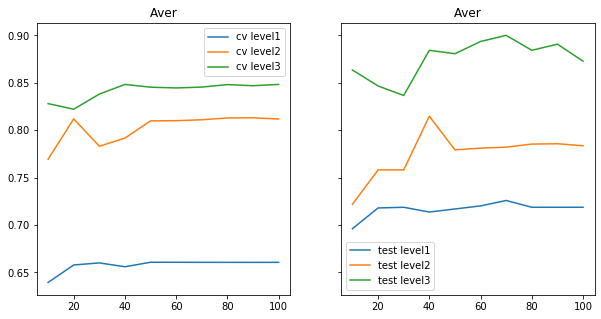

In [128]:
p = 'Aver'
parc =  df[df['ensemble']==p]
parc = parc.sort_values(['level','sparsity'])
x = parc['sparsity'].values
y_cv = parc['cv_mean'].values
y_test = parc['test_mean'].values

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax[0].plot(x[:10], y_cv[:10], label='cv level1')
ax[0].plot(x[10:20], y_cv[10:20], label='cv level2')
ax[0].plot(x[20:], y_cv[20:], label='cv level3')

ax[0].legend()
ax[0].set_title(p);

ax[1].plot(x[:10], y_test[:10], label='test level1')
ax[1].plot(x[10:20], y_test[10:20], label='test level2')
ax[1].plot(x[20:], y_test[20:], label='test level3')


ax[1].legend()
ax[1].set_title(p);

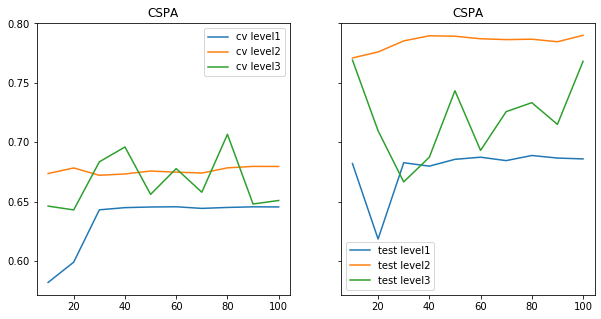

In [129]:
p = 'CSPA'
parc =  df[df['ensemble']==p]
parc = parc.sort_values(['level','sparsity'])
x = parc['sparsity'].values
y_cv = parc['cv_mean'].values
y_test = parc['test_mean'].values

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax[0].plot(x[:10], y_cv[:10], label='cv level1')
ax[0].plot(x[10:20], y_cv[10:20], label='cv level2')
ax[0].plot(x[20:], y_cv[20:], label='cv level3')

ax[0].legend()
ax[0].set_title(p);

ax[1].plot(x[:10], y_test[:10], label='test level1')
ax[1].plot(x[10:20], y_test[10:20], label='test level2')
ax[1].plot(x[20:], y_test[20:], label='test level3')


ax[1].legend()
ax[1].set_title(p);

In [114]:
x

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100,  10,  20,  30,
        40,  50,  60,  70,  80,  90, 100,  10,  20,  30,  40,  50,  60,
        70,  80,  90, 100])

In [101]:
df.sort_values('cv_mean', ascending=False)

,cv_mean,cv_std,test_mean,C,ensemble,level,sparsity,n_features,non_zero
104,0.851533,0.063825,0.855197,500.0,Destrieux_aparc2009,0,50,10878,2169
103,0.849074,0.067485,0.837634,500.0,Destrieux_aparc2009,0,40,10878,2177
72,0.848740,0.072363,0.868817,50.0,HE,3,30,3570,426
107,0.848562,0.065070,0.856989,500.0,Destrieux_aparc2009,0,80,10878,2153
89,0.848252,0.068705,0.872760,500.0,Aver,3,100,4005,1192
83,0.848228,0.073828,0.884229,5.0,Aver,3,40,4186,245
78,0.848099,0.070247,0.884946,500.0,HE,3,90,3486,1153
87,0.848039,0.068689,0.884229,500.0,Aver,3,80,4005,1188
76,0.847477,0.074371,0.875986,0.3,HE,3,70,3655,153
105,0.847272,0.068568,0.837993,500.0,Destrieux_aparc2009,0,60,10878,2205


In [102]:
df.sort_values('test_mean', ascending=False)

,cv_mean,cv_std,test_mean,C,ensemble,level,sparsity,n_features,non_zero
79,0.825247,0.075570,0.930824,300.0,HE,3,100,3570,896
86,0.845429,0.069191,0.900000,500.0,Aver,3,70,4005,1187
75,0.834850,0.076292,0.894982,20.0,HE,3,60,3570,314
85,0.844519,0.070858,0.893548,500.0,Aver,3,60,4005,1205
88,0.846874,0.071763,0.890681,500.0,Aver,3,90,4005,1174
78,0.848099,0.070247,0.884946,500.0,HE,3,90,3486,1153
83,0.848228,0.073828,0.884229,5.0,Aver,3,40,4186,245
87,0.848039,0.068689,0.884229,500.0,Aver,3,80,4005,1188
84,0.845292,0.068111,0.880645,500.0,Aver,3,50,4005,1189
76,0.847477,0.074371,0.875986,0.3,HE,3,70,3655,153


In [14]:
a = """
1 Introduction
The ability to quantify how the human brain is interconnected in vivo has opened the door to a number of possible analyses. Connectome markers ranging from the simple graph descriptors such as edge weights and nodal degrees to sophisticated graph-theoretical measures have all been invoked in the study of the brain. At the time of this writing, dozens of studies examining the effects of genetics and disease on structural and functional brain connectivity have been published (Lynall et al. 2010; Xu et al. 2016; Jiang et al. 2019; Sun et al. 2014; Jahanshad et al. 2013; Shah et al. 2017; Horovitz 2012). In nearly all of these, brain parcellation plays a crucial role. Variations in parcellation significantly impact connectome reproducibility, derived graph-theoretical measures, and the relevance of connectome measures with respect to biological questions of interest (de Reus and van den Heuvel 2013; Petrov et al. 2017). Global topological properties of individual connectome models can vary substantially depending on the parcellation used (de Reus and van den Heuvel 2013). This remains true even in the absence of any other variation, e.g. for an identical tractography reconstruction, or the same rs-fMRI pre-processing and correlation approach. In short, the utility and interpretability of in-vivo connectome measures depends to a great extent on the parcellation. For this reason, in recent years much attention has been given to both parcellation-free  approaches and parcellations derived specifically to attain some desired property in the implied connectivity graph. This approach uses individual densely sampled connectomes to drive the parcellation directly, leading to a more compact, connectivity-aware set of brain regions and resulting graph, as done in e.g. (Parisot et al. 2016). A comprehensive review of parcellation methods and their effects on the derived connectome quality is given in (Arslan et al. 2018). Because individual connectivity data is at once very informative and highly redundant, there is a great flexibility in how parcels can be derived from dense, highly resolute graphs. It is possible for example to  derive (1) a unified population-based atlas, (2) individual-level parcellations with cross-subject label mapping, or (3) individual parcellations with no inter-subject label correspondence. While the first approach is appealing for its simplicity and ease of interpretation, the second and third may enable the researcher to reveal some individual aspect of the connectome that is lost in the aggregate atlas. 
In this work, we attempt to bridge these three approaches by first constructing maximally flexible hierarchical parcellations, and then finding a unifying set of labels and parcels to maximize individual agreement. 

[Some context here for different approaches, e.g. constructing a whole-cohort graph and clustering, group-spectral clustering, or actual correspondence-free averaging. Last one hasn’t been done until now. Stress benefit of identifying optimal number and geometry of partitions (number is not constrained)]

We use a continuous representation of diffusion MRI-based brain connectivity (Moyer et al. 2017) as our initial dense connectome. Continuous connectivity is a parcellation-free representation of tractography-based, or “structural”' connectomes that is based on a generalization of the Poisson point process. Once individual parcellations are computed, we obtain a group-wise parcellation using two partition ensemble algorithms. The primary novelty of the approach comes from its ability to find an average partition without label correspondence in individual parcellations. Individual partitions retain the ability to compactly represent the unique topological structure of the connectome, while the average can be cast as a Karcher mean with respect to a measure of label agreement. Two methods of ensemble construction are presented. The first approximates the average partition by parcellating an aggregate graph of inter-individual membership agreements. The second instead attempts to find the label agreement-optimal ensemble directly via a greedy recursive minimization. All experiments are performed on 425 subjects from the Human Connectome Project. The ensemble construction procedures are shown to be stable, and approximate the average parcellation well. Further, individual connectomes implied by the ensemble parcellation are shown to be more faithful and more compact representations of the underlying dense connectome than several anatomical atlases. We summarize the concept in Figure 1.

2 Materials and Method
In this section, we introduce methods for obtaining individual and group cortical parcellations from a set of N subjects. Throughout the paper we will work with two different entities, both represented as a network: brain surface mesh, denoted by M,  and structural connectivity network, denoted by W. Individual brain surfaces are registered to the same reference (Glasser et al. 2013), therefore all subjects’ surfaces share the same set of nodesv1...vK. Accordingly, every individual structural connectivity network Wi(Continuous Connectome (Moyer et al. 2017)) is represented in a form of KKadjacency matrix and constructed upon the same set of v1...vK nodes.  Every edge Wiu,vrepresents how two cortical regions: u and v are connected in subject i. Thus, we have 1 to 1 correspondence between vertices of individual connectomes and the cortical surface mesh. Below we will omit the subject index i where possible. 

2.1 Continuous connectome
The continuous connectome model (ConCon) treats each tract as an observation of an inhomogeneous symmetric Poisson point process with the intensity function given by
:  R+,
where  denotes the union of two disjoint topologically spherical brain hemispheres, representing cortical white matter boundaries. In practice, ConCon can be treated as a discrete connectivity graph with nodes defined by mesh vertices. Thus (x,y) is an analog of an adjacency matrix.
From such a representation, a coarser discrete connectivity graph can be computed from any cortical parcellation C. We follow the definitions from (Moyer et al. 2017)  and call C =Euu=1..Z  a parcellation of  if E1,..., EZsuch that u=1ZEu= and Z is the number of  parcels. 
Edges between regions Eu and Ev can then be computed by the integration of the intensity function:
(Eu, Ev)=Eu    Ev  (x, y) dx dy,                                              (1)
due to properties of the Poisson Process, (Eu, Ev)  is the expectation of the number of observed tracts between Eu and Ev. In the context of connectomics, this is the expected edge strength.

2.2 Individual parcellation
In order to obtain subject level parcellation of a surface mesh M we cluster vertices of the associated network W. The resulting clustering C could be represented by a vector of length K :  C = {c1,...,cK}, such that cj is the “color” or index of node vj of network W.  We treat partitions that are different up to cluster index permutation as equivalent; e.g., [1,1,1,0,0],  [0,0,0,1,1]and [2,2,2,5,5] all represent the same partition of 5 objects. As the nodes of W and Mare homologous across all subjects,  we treat clusters of W as parcels of M (Figure 1E, F). The process of applying a parcellation onto matrix Wis represented on Figure 2A, B. Throughout the paper, we will use terms cluster, community, parcel, and color (node color) interchangeably. 
Intuitively, graph clustering seeks to group graph nodes clusters in such a way that nodes within the same cluster are densely connected, while inter-cluster connections are sparse. There are several ways to formalize this intuition. Here, we cluster subject-level connectomes by optimizing their graph modularity score, defined for a given clustering C as
Q(W, C) = 1m u,vK(Wu,v - dudvm)(u,v),
where du=1KWu,v is a node udegree, and (u, v) is the Kronecker delta.
We use the Louvain modularity algorithm (Blondel et al. 2008), as it has shown good results in multiple neuroimaging studies (Nicolini et al. 2017; Taylor et al. 2017; Kurmukov et al. 2017; Meunier et al. 2010; Williams et al. 2019). We note that the overall goal of this work - approximating average parcellations - is agnostic with respect to the individual clustering algorithm.  The Louvain approach initializes all nodes as separate clusters and applies an iterative two-step procedure. The first step performs a greedy modularity optimization by iteratively clustering nodes so long as the new membership assignment increases the modularity score. The second step builds a new meta graph, whose nodes are communities from the previous step, while the edges are defined as in eq. 1. The algorithm cycles over these steps iteratively, until further cluster merging ceases to increase modularity (Blondel et al. 2008).  
The algorithm produces so-called hard clusters, or a partition: a set of disjoint communities, where every node is assigned to no more than one cluster. Since Louvain modularity tends to produce relatively large communities, we follow the hierarchical brain concept (Meunier et al. 2010), repeating the clustering procedure recursively. After the initial parcellation, we further cluster each individual parcel as an independent graph. In this work, we repeat the process three times. For each dense “continuous” connectomeWi this procedure yields a three-level hierarchically embedded partition: CI, CII, CIII see fig. B . To  prevent  individual  regions  from  becoming  too  small, we forbid subdivision of parcels containing fewer than 1 percent of all vertices.
We obtain partitions, and their corresponding connectome models (eq. 1), for every subject individually and independently at each refinement level. The number of nodes in the new  connectome model corresponds to the number of communities in the individual parcellation C. In general, different subjects have different numbers of nodes without node correspondence across the dataset (Table 2). 

2.3 Group parcellation
Anatomical parcellations of different brains by the same atlas differ only in geometry. In this case, region labels are homologous across subjects and the notion of an average anatomical parcellation is equivalent to a registration problem. However, as we saw in the previous section, this is not the case for connectivity-based parcellations. Region labels are arbitrary and simple averaging of subject-level cluster assignments for each vertex is not possible. To address this we turn to the concept of consensus clustering. The goal of consensus clustering is to aggregate multiple partitions of the same, or homologous set of objects, in our case the mesh vertices across a set of registered cortical surface models. We define the average partition of all individual partitions Ci as: 
C*= argminCiNd(Ci, C*)					(2)
where  C* denotes the desired average partition, N is the number of averaged partitions, and d(Ci, C*) is a distance measure between two partitions. Finding C*is generally NP-complete (Vega-Pons and Ruiz-Shulcloper 2011), but several algorithms enable approximate solutions. In this work we adapt two separate approaches: the Cluster-based Similarity Partitioning Algorithm (CSPA) (Strehl and Ghosh 2002), and the Hard Ensemble approach (HE) (Dimitriadou et al. 2002). We note that while CSPA has been previously adapted in connectome clustering aggregation, HE 

CSPA defines similarity between objects based on co-occurrence in the same cluster across different partitions. The average clustering, or clustering ensemble, is then a partition of a graph induced by this similarity. Specifically, given multiple partitions C1,...,CN of a set of arbitrary objects v1,...,vK one can construct a network with the nodes corresponding to the objects, and the edges defined as
S(va, vb) = i=1N(Ci(a), Ci(b))				(3)
Here  again  is the Kronecker delta, and Ci(a), Ci(b) represent colors of objects va and vb. Therefore S(va, vb) is the number of individual partitions that assigns va and vb to the same cluster. By clustering this graph S we obtain an approximate consensus partition.

The Hard Ensemble algorithm is instead based on a greedy optimization of eq. 3. (Dimitriadou et al. 2002).  Partition distance d(*,*) is defined as the difference in membership functions up to permutation:
d(Pi, Pj) = 1KZk=1Kl=1L(Pik,l - Pjk,l)2
Here Pi,jare binary membership matrices of size KL (LK) encoding two different data partitions, where L is the total number of communities in partition C. Pk,l=1 if C(k)=l, i.e. if object k has cluster label l,  and 0 otherwise. For disjoint clusters each row of P contains only one non-zero entry. As with the vectorial representation C, P is defined up to label index permutation, i.e. up to any column permutation . The optimization procedure is performed with respect to all possible . In practice, as generally Li≠Lj, we set L = max(Li,Lj)and pad the matrix with fewer clusters with all-zero columns. 

HE combines multiple partitions C1,...,CNsuccessively. First averaging a pair of subjects to obtain C*12, we proceed to find a weighted average C*123 of  C*12 and subject C3, and so on until subject CN is averaged with C*1..(N-1)to obtain C*=C*1..N.  The HE optimization procedure is order dependent: averaging C1, C2, C3 and C2, C3, C1may yield different results. We address this problem in section 2.6.

In addition to ensemble clustering, we devise a far simpler methodThe third method to obtain group parcellation from individual connectomes does not use the concept of ensemble clustering. We compute average connectome: W* = 1NiWi, and cluster it using Louvain modularity algorithm, we further cluster each parcel as an independent graph, following procedure from section 2.2. This procedure is repeated for networks of all sparsity levels (10%,...,100%), see section 2.6. We refer to this method as Average.

2.4 Comparison metrics
In this section, we describe approaches to assess the quality of our average parcellation. The first quality measure is the distance between the original continuous Poisson function (x, y) and its piecewise constant approximation given by:  
(x,y) =1|Ei||Ej|(Ei, Ej) ,
where x EiandyEj, and |Ei|, |Ej| are expected nodal degree of regions Ei, Ejrespectively.
The natural way to compare two statistical distributions is to measure the distance between their probability density functions. Following  (Parisot et al. 2015) we use Kullback-Leibler divergence (Kullback and Leibler 1951):
KL(, ) = -+(u) (u)(u)du,
where (u), (u)are vectorized versions of  (x, y) and  (x, y) respectively. The intuition here is that networks derived using “better” parcellation should have lower values of KL divergence from original Continuous Connectome since they are better at capturing internal graph structure. Also, networks derived from parcellations with more parcels should generally have lower KL.
In order to quantify the goodness of consensus clustering:
dtot = 1NiNd(Ci,C*)
we use Adjusted Mutual Information (AMI) (Vinh et al. 2009), a variant of Mutual Information. 
AMI measures the similarity between two partitions, with the value of 1 corresponding to identical partitions and values close to zero corresponding to partitions that are very different. AMI is an adjusted version of Mutual Information. Given two different partitions X and Y of K objects, we Mutual Information could be computed as follows. First, we build a contingency table T, such that rows of this table correspond to clusters of one partition, and columns correspond to clusters of another partition  and  Tij = |Xi Yi | - number of objects that are both in cluster i of the first partition and in cluster j of the second. Next, MI is computed using the formula:
MI(X, Y) = iZxj  Zy pijpijpipj,
where Zx, Zy are the number of clusters in partitions X and Y respectively, pi = |Xi|K, pij=TijK. Among multiple options to adjust Mutual Information for chance we use AMImax:
AMImax(X, Y) = MI(X, Y) - E(MI(X, Y))max(H(X), H(Y))-E(MI(X, Y)),
where H(X)= -iZxpi pi is the entropy, and the expectation is computed based on the permutation model as in (Vinh et al. 2009).
We also use AMI for other comparisons: to assess hemisphere symmetry, to compare different parcellations between themselves, to assess HE ensembling stability (between different averaging orders). AMI is a measure of similarity, we use 1 - AMI as a measure of dissimilarity or distance:
d(Ca, Cb) = 1 - AMI(Ca, Cb),
however, it is not a proper metric since triangle inequality does not necessarily hold for it.
We also use several other characteristics. To measure parcellation spatial connectivity (intuitively desirable property, however, we do not use any constraints to enforce it) we use the percentage of mesh vertices that are assigned to spatially connected regions/parcels. To measure classification (gender) performance (if parcellation is good, it should be possible to discriminate between women and men) we use ROC AUC score, popular classification metric which allows for imbalanced classes. Finally, we assess the stability of networks derived from group parcellation compared to those from individual parcellations. We assume that global network characteristics such should be preserved in a network obtained using ensemble parcellation compare to network derived using individual parcellation or anatomical one. We use clustering coefficient (CC) and average path length (APL) (Rubinov and Sporns 2010). The idea is the following, if ensemble parcellation is good it should preserve individual features of a subject’s network. For example consider two networks, one has lower CC then the other in . Therefore for every subject we compare its Average Clustering coefficient and Average Path length derived from network obtained using individual parcellation, and network, obtained using ensemble parcellation, see Figure.


2.5 Data preprocessing
We use data of 425 subjects 167 men, mean age 28.0 (3.7), 258 women, mean age 29.3 (3.6)  from the Human Connectome Project S900 release (Van Essen et al. 2013). We use an icosahedral spherical sampling, at a resolution of 10242 mesh vertices per hemisphere. We used Dipy's implementation of constrained spherical deconvolution (CSD) to perform probabilistic tractography. Before, we exclude all mesh vertices labeled by FreeSurfer as corpus callosum or cerebellum. 
We run FreeSurfer recon-all to obtain cortical meshes for all subjects and Desikan-Killiany, Destrieux. We reconstruct each subject's continuous connectome following the protocol in (Moyer et al. 2017).

2.6 Experimental pipeline
Since tractography method could lead to False Positive connections, we thresholded edges with a small weight, resulting in networks with 10 different sparsity levels: 10% of original edges (heaviest 10% edges), 20%,...,100% (=no threshold).  All experiments were conducted for every sparsity level.
In our experiments, we examine three important aspects of our group parcellations. First of all, there are two essential tests that any concept of averaging (group parcellation is an “average” of subjects parcellations) must pass: 
Stability of the average construction itself, for example, whether  group parcellations reconstructed from different subsets of subjects are similar; 
The degree to which the average object is “in the middle” of the sample used to construct it, i.e. its goodness of fit as an average. 
The third aspect is related to connectomic analysis. In a context of connectomic analysis, applying parcellation is a method to decrease dimensionality, decrease noise i.e. False Positive and False Negative edges (Zalesky et al. 2016) and thus increase signal level, therefore parcellation should:
Accurately approximate structural connectivity of the brain.
We start by applying Louvain (three-level procedure) algorithm to Continuous Connectomes of all sparsity levels, thus for every subject we obtain 30 different parcellations. Next, we aggregate individual subject partitions and obtain consensus clustering using both CSPA and HE. This is performed separately for each of the three subdivision levels, producing a total of 60 candidate ensemble parcellations (six for every sparsity level). We also compute average connectome and cluster it using Louvain (again at three levels and 10 sparsities). Finally, we apply Desikan-Killiany (Desikan et al. 2006) and Destrieux (Destrieux et al. 2010) parcellations (derived from FreeSurfer recon-all). Desikan and Destrieux parcellations were averaged by a majority rule, since their regions are uniquely labeled. Thus, for every continuous connectome representation, we obtain 110 connectomes. 
To measure intrinsic parcellation stability, we sample 100 random halvings of our 426 subjects and compute ensembles (100) from them, next we compare them using AMI (all pairwise comparisons, total of  10099 / 2=4950). Finally, as the HE algorithm depends on averaging order, we test how hard it affects the ensemble using 100 randomly permuted orders of all 426 subjects (again, all pairwise comparisons). The results of these experiments are presented on fig. C. 
We test the goodness of fit of our ensemble procedure based on two concepts: 
Intrinsic label agreement. 	
Stability of global network characteristics (Rubinov and Sporns 2010).
The degree to which the ensemble themselves are an average of the sample can be assessed simply by computing the AMI of the ensemble and each individual parcellation:
1NiNAMI(Ci, C*),
we term this measure “ensemble goodness”. We compare global network characteristics (Average Path Length, Degree Distribution, and Average Clustering Coefficient) for connectomes derived using subject-level parcellations and ensemble parcellation.
Next, we evaluate how accurate is parcellation with respect to connectivity patterns. First, we assess the utility of the ensemble with respect to connectome representation. For this purpose we use the KL divergence on edge weight distributions. Second, we measured the utility of the resulting connectome representation with respect to biological questions of interest. As a basic example of such a question, we take the sex classification task. We compare the performance of simplified connectomes on this binary classification task using Logistic Regression with l1penalty. To avoid overfitting we compute ensemble parcellation on one half of subjects and then apply it to the other half. Classification results were estimated on the second half of the data. We take edge weights (upper triangle of an adjacency matrix, as a vector) as a feature representation of our objects. Thus, for every parcellation with Z regions, we have Z(Z-1)/2 features. Classification results were measured using ROC AUC score. Validation procedure is bi-level KFold. First level was used to obtain optimal Lasso penalization parameter, second was used to assess classification performance.
Beyond measuring parcellation stability, the goodness of fit and accurateness of network structure estimation we additionally measure:
Inter-hemispheric symmetry in the ensemble parcellation, as our original cortical mesh representations are in symmetric vertex-wise register.   
Spatial contiguity of resulting group atlas.
The similarity between connectivity driven parcellations (HE, CSPA and Aver) and anatomical parcellations (Desikan-Killiany and Destrieux).


3 Results
As we mentioned earlier, the task of constructing a parcellation is vague, therefore we need to compare obtained parcellations in multiple ways. 
We start with analysing parcellation’s stability. All proposed methods are highly stable with respect to edge thresholding (network’s sparsity) and  subject sampling: Table 1 summarizes stability testing results for all parcellations at level 3. Also, diagonal values of Figure 2 show average similarity between parcellations obtained using the same method but different network’s sparsity level, for anatomical parcellation it is equal to 1 (since they do not depend on network’s sparsity). Finally, uncertainty of HE  ensembling algorithm with respect to subject’s averaging order is negligible, the similarity between 100 different (order) ensembles is very high: .91 (.02) average AMI. Thus, we can conclude that Aver and HE approaches are stable in all cases, and CSPA<...>. The main problem with CSPA is that it failed to to find number of parcels comparable with number of parcels in individual networks. Individual partitions have 9 (2), 35 (4), 96 (7) clusters for level1, level2, level3 respectively (mean (std), distribution is taken over all subjects). However, after ensembling them using CSPA we end up with only  7, 8, 10 clusters. This could be due to the same reason we already mentioned in section 2.2, Louvain tends to find large communities.
We proceed with measuring  how good is our averaging techniques.  Average similarity with subject parcellation is the highest for HE3however, Aver3is a close contestant (Table 1.). Next, we compare global network characteristics: how stable are average path length and average clustering coefficient when we switch from subject parcellation to ensemble one. First of all, these characteristics should be of reasonable order, therefore we compute them for anatomical parcellations: Desikan, Destrieux, Figure 4 shows that all methods (except CSPA3 which has a small number of clusters, therefore anomalous values of APL and CC) agree in absolute values. They also demonstrate adequate values of Clustering Coefficient (high clustering) and Average Path length (short paths), as reported earlier for brain networks.  Secondly, we compare correlation between characteristics derived from networks obtained using different parcellations. Moreover, network obtained using ensemble parcellation preserve both CC and APL at least to some extent: Table 2 demonstrates correlation between individual and ensemble networks. We believe that CSPA approach fails in most cases because it has a relatively small number of parcels compared to individual parcellations at every level. However HE and Aver show very good results. Finally, we compute how good is our method in capturing discriminating differences between men and women. Though the result of gender classification is not interesting by itself, we expect to have similar performance for our parcellations and anatomical ones. Surprisingly, even parcellation with small number of regions (CSPA2) is almost as good at this task as any other.
Next, we assess how good are our parcellations in approximating original ConCon. As we can see from Table 1 KL divergence is generally smaller for parcellations with more regions. However, our best parcellation HE3has almost 2 times less parcels then Destrieux and yet almost equal KL divergence. Same holds for HE2in comparison with Desikanparcellation.
This result means that the internal connectivity structure of the original ConCon is caught at least as good as with anatomical parcellations but with lesser parcels.
Finally, we analyse some natural parcellation properties. As we can see from Table 1, our parcellations (HE, Aver) demonstrate both high hemisphere symmetry and parcels contiguity. This result is especially interesting since the approach has no specific spatial constraints and  graph clustering is computed on the whole network (without dividing it into left and right hemisphere). We also observe that resulting connectivity parcellations are highly similar to anatomical parcellations as shown in Figure 2. For example, similarity between HE3and Desikanis the same as similarity between Desikanand Destrieux.
4 Discussion



5 Conclusion
We have presented an approach for generating unified connectivity-based human brain atlases based on consensus clustering. The method is based on finding a pseudo average over the set of individual partitions. Our approach outperforms standard an anatomical parcellation on several important metrics, including agreement with dense connectomes, improved relevance to biological data, and even improved symmetry. Because our approach is entirely data driven a requires no agreement between individual parcellation labels, it combines both the flexibility of individual parcellations and the interpretability of simple unified atlases.

6 Acknowledgements
<...>





"""

In [15]:
len(a.split(' '))

4281